In [112]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


seed=1245
np.random.seed(1245)
tf.random.set_seed(1245)

In [113]:
tf.executing_eagerly()
tf.config.list_physical_devices('GPU')
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[]

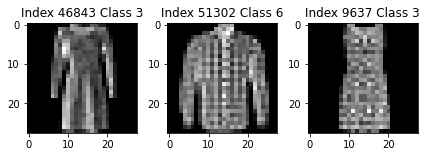

In [114]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

# Important
* Always have a validation set, the procedure to create validation or dev set is by performing random sample without replacement on train set and then only using that fraction as dev set. 
* Simple approach is to set some K samples, you can extract them from start, mid or end.
* Imagine validation set that partially approximates test set distribution and we assume our model would produce identical results when we test it on test set.
* Always optimize your hyperparameters by looking at performance on validation set and not test set.
* Do not touch test set, we have this to test how our model would work on unseen data.

In [115]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


# Points to remember
* If using any type of neural network, normalize your input between 0-1.
* One can use various procedures to achieve this, divide by largest value (for images we use 255), subtract mean from data and then normalize, one can even augment them and use other steps for normalization.
* Normalization is important step, one could observe significant boost in performance just by having better normalization scheme.
* For targets we always use one-hot encodings.

In [116]:
#Normalize Data

X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0
# X_train[0]
np.max(X_train)

1.0

In [117]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

batch_size=128
lr=0.1

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

print(tf.shape(y_val))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000], shape=(1,), dtype=int32)
tf.Tensor([10000    10], shape=(2,), dtype=int32)


# Importance of weight initialization

* One reason backprop based models can perform bettter lies with the weight initialization method, one important point one should remember is that, if yur weights are initialized to be too high or low, backprop would struggle.
* Hence one should always carefully initialize weights of your model, below i have shown approach with random_normal, one can use random_uniform, truncated version of both, Xavier init and orthogonal. 
* You will find modern day NNs have achieved stable and better performance by simply switching to better init and majority of cases Xavier or Orthogonal works best.
* Always initialize your bias using zero or some small constant (ideally 0.01 or less works better). We use bias to shift the activation and in some cases it can stabalize learning, but having large bias can cause negative results.

# Loss function

* We will always cross-entropy loss for classification.

* tf softmax,
loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf)), this function is simply saying that it will calculate softmax for you, simply provide logits to it. 

* In other output of your forward pass directly goes this function. Now this operator will calculate or apply softmax over prediction or logits and calculate cross-entropy between prediction and target. I am using reduce_mean since we apply this over batches.
* Second is using keras
Method 1 :- This function requires logits, hence same as above you will pass logits or output variable to this function. Now remember you need from_logits = True, for this to work.
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss_x = cce(y_true_tf, y_pred_tf) 

* Method 2:- In this we will apply softmax to output function and then pass to CCE loss.
So the approach is 
output = tf.nn.softmax(output)
cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss_x = cce(y_true_tf, y_pred_tf) 

In [118]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device

    self.initial=tf.keras.initializers.he_normal(seed=seed)
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(self.initial([self.size_input, self.size_hidden1])) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(self.initial([self.size_hidden1, self.size_hidden2]))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(self.initial([self.size_hidden2, self.size_hidden3]))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(self.initial([self.size_hidden3, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))

    self.gamma1=tf.Variable(tf.ones([1, self.size_hidden1]))
    self.beta1=tf.Variable(tf.zeros([1, self.size_hidden1]))

    self.gamma2=tf.Variable(tf.ones([1, self.size_hidden2]))
    self.beta2=tf.Variable(tf.zeros([1, self.size_hidden2]))

    self.gamma3=tf.Variable(tf.ones([1, self.size_hidden3]))
    self.beta3=tf.Variable(tf.zeros([1, self.size_hidden3]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4, self.gamma1, self.beta1, self.gamma2, self.beta2, self.gamma3, self.beta3]

    self.mean1=tf.Variable(tf.zeros([1, self.size_hidden1]))
    self.var1=tf.Variable(tf.ones([1, self.size_hidden1]))
    self.mean2=tf.Variable(tf.zeros([1, self.size_hidden2]))
    self.var2=tf.Variable(tf.ones([1, self.size_hidden2]))
    self.mean3=tf.Variable(tf.zeros([1, self.size_hidden3]))
    self.var3=tf.Variable(tf.ones([1, self.size_hidden3]))

    self.variables_untraining = [self.mean1, self.var1, self.mean2, self.var2, self.mean3, self.var3]

    self.epsilon=0.001

    #self.untrain_variables=[]
  
  def forward(self, X, training):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X, training)
    else:
      self.y = self.compute_output(X, training)
      
    return self.y

  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

  def backward(self, X_train, y_train, opti):
    """
    backward pass
    """
    optimizer = opti
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train, True)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
           
  def compute_output(self, X, training):
    """
    Custom method to obtain output tensor during forward pass
    """
    if training==True:
      # Cast X to float32
      X_tf = tf.cast(X, dtype=tf.float32)
      #X_tf = X
      
      # Compute values in hidden layers
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      h1 = tf.nn.relu(z1)
      mean1=tf.math.reduce_mean(h1, 0)
      var1=tf.math.reduce_variance(h1, 0)
      h1 = (h1-mean1)/tf.math.sqrt(var1+self.epsilon)*self.gamma1+self.beta1
      
      z2 = tf.matmul(h1, self.W2) + self.b2
      h2 = tf.nn.relu(z2)
      mean2=tf.math.reduce_mean(h2, 0)
      var2=tf.math.reduce_variance(h2, 0)
      h2 = (h2-mean2)/tf.math.sqrt(var2+self.epsilon)*self.gamma2+self.beta2
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      h3 = tf.nn.relu(z3)
      mean3=tf.math.reduce_mean(h3, 0)
      var3=tf.math.reduce_variance(h3, 0)
      h3 = (h3-mean3)/tf.math.sqrt(var3+self.epsilon)*self.gamma3+self.beta3

      # Compute output
      output = tf.matmul(h3, self.W4) + self.b4
      
      #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
      # Second add tf.Softmax(output) and then return this variable
    elif training==False:
      # Cast X to float32
      X_tf = tf.cast(X, dtype=tf.float32)
      #X_tf = X
      
      # Compute values in hidden layers
      z1 = tf.matmul(X_tf, self.W1) + self.b1
      h1 = tf.nn.relu(z1)
      mean1=self.mean1
      var1=self.var1
      h1 = (h1-mean1)/tf.math.sqrt(var1+self.epsilon)*self.gamma1+self.beta1
      
      z2 = tf.matmul(h1, self.W2) + self.b2
      h2 = tf.nn.relu(z2)
      mean2=self.mean2
      var2=self.var2
      h2 = (h2-mean2)/tf.math.sqrt(var2+self.epsilon)*self.gamma2+self.beta2
      
      z3 = tf.matmul(h2, self.W3) + self.b3
      h3 = tf.nn.relu(z3)
      mean3=self.mean3
      var3=self.var3
      h3 = (h3-mean3)/tf.math.sqrt(var3+self.epsilon)*self.gamma3+self.beta3

      # Compute output
      output = tf.matmul(h3, self.W4) + self.b4

    return (output)

  def updateBN(self, X):
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    self.mean1=tf.math.reduce_mean(h1, 0)
    self.var1=tf.math.reduce_variance(h1, 0)
    h1 = (h1-self.mean1)/tf.math.sqrt(self.var1+self.epsilon)*self.gamma1+self.beta1
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    self.mean2=tf.math.reduce_mean(h2, 0)
    self.var2=tf.math.reduce_variance(h2, 0)
    h2 = (h2-self.mean2)/tf.math.sqrt(self.var2+self.epsilon)*self.gamma2+self.beta2
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)
    self.mean3=tf.math.reduce_mean(h3, 0)
    self.var3=tf.math.reduce_variance(h3, 0)
    h3 = (h3-self.mean3)/tf.math.sqrt(self.var3+self.epsilon)*self.gamma3+self.beta3
    
    return
    

#  def stderr(self,y_pred):
#     """
#      Calculate standard error
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     std_err = std_dev/sqrt(len(y_pred_tf))
#     return std_err 


#  def var(self,y_pred):
#     """
#      Calculate variance 
#      """
#     y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#     std_dev = np.std(y_pred_tf) #Calculates standard deviation
#     variance = (std_dev**2) # calculate variance
#     return variance 



Epoch 0, Val Loss: 2.3452987670898438, Val Accuracy: 11.6899995803833
Epoch 1, Loss: 0.3526662588119507, Accuracy: 87.18199920654297, Val loss: 0.3897859454154968, Val Accuracy: 85.93999481201172
Epoch 2, Loss: 0.30457186698913574, Accuracy: 88.69400024414062, Val loss: 0.35623419284820557, Val Accuracy: 86.80999755859375
Epoch 3, Loss: 0.2752203047275543, Accuracy: 89.88199615478516, Val loss: 0.34102606773376465, Val Accuracy: 87.29000091552734
Epoch 4, Loss: 0.2592344582080841, Accuracy: 90.4280014038086, Val loss: 0.34154218435287476, Val Accuracy: 87.33999633789062
Epoch 5, Loss: 0.2398396134376526, Accuracy: 91.00199890136719, Val loss: 0.3383128345012665, Val Accuracy: 87.4800033569336
Epoch 6, Loss: 0.22419464588165283, Accuracy: 91.68000030517578, Val loss: 0.33648398518562317, Val Accuracy: 87.9000015258789
Epoch 7, Loss: 0.20678359270095825, Accuracy: 92.33399963378906, Val loss: 0.33381858468055725, Val Accuracy: 87.91000366210938
Epoch 8, Loss: 0.1958901435136795, Accuracy

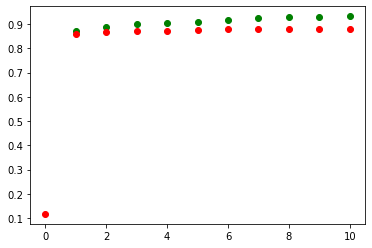

In [119]:
NUM_EPOCHS = 15
opti = tf.keras.optimizers.SGD(learning_rate = 0.1)
#opti = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum=0.9)
#opti = tf.keras.optimizers.RMSprop(learning_rate = 1e-3)
#opti = tf.keras.optimizers.Adam(learning_rate = 1e-4)
#opti = tf.keras.optimizers.Nadam(learning_rate = 1e-4)



train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.CategoricalAccuracy(name='val_accuracy')

train_loss.reset_states()
train_accuracy.reset_states()
val_loss.reset_states()
val_accuracy.reset_states()

mlp_on_default = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output)

valid_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(X_val.shape[0])
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=seed).batch(batch_size)
train_ds_all = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(X_train.shape[0])

for inputs, outputs in valid_ds:
  preds = mlp_on_default.forward(inputs, False)
  val_loss(mlp_on_default.loss(preds,outputs))
  val_accuracy(outputs, preds)

print(
  f'Epoch {0}, '
  f'Val Loss: {val_loss.result()}, '
  f'Val Accuracy: {val_accuracy.result() * 100}'
)
plt.plot(0, val_accuracy.result(), 'ro-',label="Validate accuracy")

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*seed).batch(batch_size)
  
  for inputs, outputs in train_ds:
    mlp_on_default.backward(inputs, outputs,opti)

  '''
  for i in range(len(mlp_on_default.variables)):
      print(mlp_on_default.variables[i].name)
  print("---------------------------------------")
  for i in range(len(mlp_on_default.trainable_variables)):
      print(mlp_on_default.trainable_variables[i].name)
  '''
  
  for inputs, outputs in train_ds_all:
    mlp_on_default.updateBN(inputs)
  #print(mlp_on_default.variables_untraining[0])

  for inputs, outputs in train_ds_all:
    preds = mlp_on_default.forward(inputs, False)
    train_loss(mlp_on_default.loss(preds,outputs))
    train_accuracy(outputs, preds)

  for inputs, outputs in valid_ds:
    preds = mlp_on_default.forward(inputs, False)
    val_loss(mlp_on_default.loss(preds,outputs))
    val_accuracy(outputs, preds)
  
  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Val loss: {val_loss.result()}, '
    f'Val Accuracy: {val_accuracy.result() * 100}'
  )
  plt.plot(epoch + 1, train_accuracy.result(), 'go-',label="Train accuracy")
  plt.plot(epoch + 1, val_accuracy.result(), 'ro-',label="Validate accuracy")

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

In [120]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

test_loss.reset_states()
test_accuracy.reset_states()

train_ds_all = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(X_train.shape[0])
for inputs, outputs in train_ds_all:
  mlp_on_default.updateBN(inputs)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(X_test.shape[0])

for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs,False)
  test_loss(mlp_on_default.loss(preds,outputs))
  test_accuracy(outputs, preds)

print(
  f'Test Loss: {test_loss.result()}, '
  f'Test Accuracy: {test_accuracy.result() * 100}'
)

Test Loss: 0.37172186374664307, Test Accuracy: 87.62000274658203
